In [1]:
# libraries
import os
import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import sklearn
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GroupKFold,
    KFold,
    RepeatedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)
from xgboost import XGBRegressor

# Set the maximum number of columns to display
pd.set_option("display.max_columns", 30)

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
emp = pd.read_csv("employment_status.csv")
ss = pd.read_csv("SampleSubmission.csv")
income = pd.read_csv("income_group.csv")
custom = pd.read_csv("customer.csv")
transaction = pd.read_csv("transactions.csv")

In [3]:
train.head()

CUSTOMER_IDENTIFIER RECORD_DATE  \
0  ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...     2022-07   
1  ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...     2022-04   
2  ID_fbf3035c5b8e7da652269551c78d634a48bca823076...     2022-06   
3  ID_a0081832892639d933929e24ce46203ea417e17ecbe...     2022-08   
4  ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...     2022-07   

  DECLARED_NET_INCOME  
0              13,500  
1               9,000  
2               8,000  
3               7,000  
4              10,400

In [4]:
test.head()

CUSTOMER_IDENTIFIER RECORD_DATE
0  ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...     2022-06
1  ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...     2022-01
2  ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...     2022-05
3  ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...     2022-05
4  ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...     2022-03

In [5]:
transaction.head()

TRANSACTION_DESCRIPTION                                CUSTOMER_IDENTIFIER  \
0                     NaN  ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...   
1                     NaN  ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...   
2            POS PURCHASE  ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...   
3                     NaN  ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...   
4                     NaN  ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...   

                 RECORD_DATE  \
0  2022-07-13 00:00:00+02:00   
1  2022-02-26 00:00:00+02:00   
2  2022-07-26 00:00:00+02:00   
3  2022-03-27 00:00:00+02:00   
4  2022-05-06 00:00:00+02:00   

                                   ACCOUNT_TYPE_CODE  ACCOUNT_BALANCE  \
0  9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...          1857.56   
1  9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...          8843.46   
2  e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...            23.82   
3  9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...           198.11   
4  9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...         13631.60   

       AMT  EVENT_NUMBER PRODUCT_CODE   CHANNEL  \
0  1000.00         11785         SAVE  internet   
1 -2000.00         11348         SAVE  internet   
2  -199.98           148         CHEQ    system   
3   -79.39         11419         SAVE    system   
4  -200.00         11528         SAVE       atm   

                                      ACCOUNT_NUMBER  \
0  89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...   
1  89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...   
2  89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...   
3  89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...   
4  89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...   

                               TRANSACTION_REFERENCE  
0                                                NaN  
1                                                NaN  
2  04ae923a903fb07b5c846eb61eda25c4766800f02c2e09...  
3                                                NaN  
4                                                NaN

In [6]:
transaction.shape, train.shape

((847544, 11), (3600, 3))

In [7]:
income.head()

income_group_code income_group_desc
0                  0      NOT SUPPLIED
1                  1         R 0 - 499
2                  2        R500 - 999
3                  3    R1,000 - 1,999
4                  4    R2,000 - 2,999

In [8]:
income.shape

(22, 2)

In [9]:
test.head()

CUSTOMER_IDENTIFIER RECORD_DATE
0  ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...     2022-06
1  ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...     2022-01
2  ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...     2022-05
3  ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...     2022-05
4  ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...     2022-03

## Here we are going to combine train and test set to better proprocess it.

here are few thing to keep in Mind:
    1. Data leakage is something that occurs when we concatinate train and test while separatin them again
    2. We should be careful about the shape of the train and the test on split

## Here I am going to use this method

Add an indicator column while concatenating the two dataframes, so you can later seperate them again:

df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
Then later you can split them again:

test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]


from this (Link)['https://datascience.stackexchange.com/questions/81617/how-to-combine-and-separate-test-and-train-data-for-data-cleaning']

we are going to concatinate our train and test data

In [10]:
data = pd.concat([train.assign(ind="train"), test.assign(ind="test")]).reset_index(
    drop=True
)

In [11]:
test.shape, train.shape

((1544, 2), (3600, 3))

In [12]:
data.head()

CUSTOMER_IDENTIFIER RECORD_DATE  \
0  ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...     2022-07   
1  ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...     2022-04   
2  ID_fbf3035c5b8e7da652269551c78d634a48bca823076...     2022-06   
3  ID_a0081832892639d933929e24ce46203ea417e17ecbe...     2022-08   
4  ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...     2022-07   

  DECLARED_NET_INCOME    ind  
0              13,500  train  
1               9,000  train  
2               8,000  train  
3               7,000  train  
4              10,400  train

In [13]:
emp.head()

employee_status_code employee_status_desc
0                     0             Resigned
1                     3               Active
2                     1             Inactive
3                     2              Retiree

In [14]:
custom.head()

CUSTOMER_IDENTIFIER DATE_LAST_UPDATED  \
0  ID_00a7d65f82a6819e79c29a84e805777f0265308b655...           2022-09   
1  ID_09651edcac6c55a5e401062b0c0ef7bbba3f3e49538...           2022-09   
2  ID_17215674e76eb33b47c4dd3ac3392e3e8f1a34b131b...           2022-09   
3  ID_212860dd16c79ea8eae97cc1fc181e6afd4862fceaf...           2022-09   
4  ID_24953f74da44bd0915c4cb78c1d97cbbd66e85bbd91...           2022-08   

   SEX_CODE  INCOME_GROUP_CODE  NUMBER_OF_ACCOUNTS  OCCUPATIONAL_STATUS_CODE  \
0         1                  6                   4                         7   
1         0                  7                  10                         3   
2         1                  7                   7                         1   
3         0                 13                  10                         1   
4         0                 13                   6                         1   

   AGE  
0   51  
1   32  
2   41  
3   44  
4   44

In [15]:
custom.shape

(5144, 7)

In [16]:
ss.head()

CUSTOMER_IDENTIFIER  DECLARED_NET_INCOME
0  ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...                    0
1  ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...                    0
2  ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...                    0
3  ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...                    0
4  ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...                    0

As they told as that account number is duplicated so we are going to drop it to see if we can get the product code, channel, and amt columns on our train test.

In [17]:
transaction = transaction.drop_duplicates(["ACCOUNT_NUMBER"])
transaction.shape

(5587, 11)

In [18]:
transaction.shape

(5587, 11)

In [19]:
transaction = transaction.iloc[:5144, :]
transaction.shape

(5144, 11)

In [20]:
transaction.head()

TRANSACTION_DESCRIPTION  \
0                       NaN   
322            POS PURCHASE   
329                     NaN   
553            POS PURCHASE   
904                     NaN   

                                   CUSTOMER_IDENTIFIER  \
0    ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...   
322  ID_0925f20edcf26977988f43469681d58441b449a88c7...   
329  ID_09b52b96ac7bc78862e8340d3a7be0fc103227f9bcc...   
553  ID_13da6738cf3191e70f74c127b14345e4ddc9bc04adc...   
904  ID_1af3755a6e5931439773fcb2ec4dda1190dfd2fece3...   

                   RECORD_DATE  \
0    2022-07-13 00:00:00+02:00   
322  2022-06-26 00:00:00+02:00   
329  2022-04-30 00:00:00+02:00   
553  2021-12-09 00:00:00+02:00   
904  2022-04-27 00:00:00+02:00   

                                     ACCOUNT_TYPE_CODE  ACCOUNT_BALANCE  \
0    9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...          1857.56   
322  e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...            24.59   
329  e17913461e7c03cd0f2c1ac41584dcd801cb32e7f86ad9...          2175.76   
553  e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...          2232.80   
904  9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...          3102.59   

         AMT  EVENT_NUMBER PRODUCT_CODE   CHANNEL  \
0    1000.00         11785         SAVE  internet   
322   -38.91            50         CHEQ    system   
329   -33.99          1656         SAVE    system   
553   -51.50         14761         CHEQ    system   
904  -333.24          8005         SAVE    system   

                                        ACCOUNT_NUMBER  \
0    89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...   
322  0e77f4d244bd3833b4aa54d3ed788a1d99e127b1cf63fd...   
329  7d7506943996ff370ac93bf43200a318fbf291013aea9a...   
553  db1d38f2520c0faeb26893765d4184bdd1c94e987ccfea...   
904  630aad4f576667271bf2848309e206465a343c8295480b...   

                                 TRANSACTION_REFERENCE  
0                                                  NaN  
322  c9681cfc2cec371c82a1d38bad5fc9416868c36d17d0df...  
329                                                NaN  
553  2156f36cc7b365fc16661bef94f3a303a3fd4c47bfa242...  
904                                                NaN

In [21]:
data = data.merge(custom, on="CUSTOMER_IDENTIFIER")
data.head()

CUSTOMER_IDENTIFIER RECORD_DATE  \
0  ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...     2022-07   
1  ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...     2022-04   
2  ID_fbf3035c5b8e7da652269551c78d634a48bca823076...     2022-06   
3  ID_a0081832892639d933929e24ce46203ea417e17ecbe...     2022-08   
4  ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...     2022-07   

  DECLARED_NET_INCOME    ind DATE_LAST_UPDATED  SEX_CODE  INCOME_GROUP_CODE  \
0              13,500  train           2022-07         0                 15   
1               9,000  train           2022-04         0                 15   
2               8,000  train           2022-08         0                  7   
3               7,000  train           2022-08         1                  9   
4              10,400  train           2022-09         0                 12   

   NUMBER_OF_ACCOUNTS  OCCUPATIONAL_STATUS_CODE  AGE  
0                   7                         1   45  
1                   5                         1   32  
2                   7                         7   59  
3                  14                         7   57  
4                  11                         1   29

## We are going to fix the data type of the target variable it's categorical we are converting it into int type
Here there is a problem we notice that there is **,** in our target variable I got help from this one: [Convert to Numerical](https://stackoverflow.com/questions/55557004/getting-attributeerror-float-object-has-no-attribute-replace-error-while)

In [22]:
data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(str)
data["DECLARED_NET_INCOME"] = [x.replace(",", "") for x in data["DECLARED_NET_INCOME"]]

In [23]:
data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(float)
# data["DECLARED_NET_INCOME"].apply(lambda x: str(x.replace(",", "").strip()))

In [24]:
data.shape, transaction.shape

((5144, 10), (5144, 11))

In [25]:
data.dtypes

CUSTOMER_IDENTIFIER          object
RECORD_DATE                  object
DECLARED_NET_INCOME         float64
ind                          object
DATE_LAST_UPDATED            object
SEX_CODE                      int64
INCOME_GROUP_CODE             int64
NUMBER_OF_ACCOUNTS            int64
OCCUPATIONAL_STATUS_CODE      int64
AGE                           int64
dtype: object

In [26]:
data["RECORD_DATE"] = pd.to_datetime(data["RECORD_DATE"])
data["YEAR"] = data["RECORD_DATE"].dt.year.astype(float)
data["MONTH"] = data["RECORD_DATE"].dt.month
data["DAY"] = data["RECORD_DATE"].dt.day
data.loc[:, "WEEKOFYEAR"] = data["RECORD_DATE"].dt.weekofyear
data.loc[:, "DAYOFWEEK"] = data["RECORD_DATE"].dt.dayofweek
data.loc[:, "WEEKDAY"] = data["RECORD_DATE"].dt.weekday
data.loc[:, "WEEKEND"] = (data["RECORD_DATE"].dt.weekday >= 5).astype(int)

<ipython-input-26-6eb5c5385962>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data.loc[:, "WEEKOFYEAR"] = data["RECORD_DATE"].dt.weekofyear


In [27]:
# converting the target to numeric

# data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(float)

# More features Engineering techniques

In [28]:
data.columns

Index(['CUSTOMER_IDENTIFIER', 'RECORD_DATE', 'DECLARED_NET_INCOME', 'ind',
       'DATE_LAST_UPDATED', 'SEX_CODE', 'INCOME_GROUP_CODE',
       'NUMBER_OF_ACCOUNTS', 'OCCUPATIONAL_STATUS_CODE', 'AGE', 'YEAR',
       'MONTH', 'DAY', 'WEEKOFYEAR', 'DAYOFWEEK', 'WEEKDAY', 'WEEKEND'],
      dtype='object')

In [29]:
data["SEX_CODE_COUNT"] = data["SEX_CODE"].map(data["SEX_CODE"].value_counts().to_dict())
data["INCOME_GROUP_CODE_COUNT"] = data["INCOME_GROUP_CODE"].map(
    data["INCOME_GROUP_CODE"].value_counts().to_dict()
)

In [30]:
data["MEAN_INCOME_GROUP_CODE_PER_MONTH"] = data["MONTH"].map(
    data.groupby("MONTH").mean()["INCOME_GROUP_CODE"]
)
data["STD_INCOME_GROUP_CODE_PER_MONTH"] = data["MONTH"].map(
    data.groupby("MONTH").std()["INCOME_GROUP_CODE"]
)
data["MAX_INCOME_GROUP_CODEr_PER_RIDER"] = data["MONTH"].map(
    data.groupby("MONTH").max()["INCOME_GROUP_CODE"]
)
data["MIN_INCOME_GROUP_CODE_PER_MONTH"] = data["MONTH"].map(
    data.groupby("MONTH").min()["INCOME_GROUP_CODE"]
)

In [31]:
data.head()

CUSTOMER_IDENTIFIER RECORD_DATE  \
0  ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...  2022-07-01   
1  ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...  2022-04-01   
2  ID_fbf3035c5b8e7da652269551c78d634a48bca823076...  2022-06-01   
3  ID_a0081832892639d933929e24ce46203ea417e17ecbe...  2022-08-01   
4  ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...  2022-07-01   

   DECLARED_NET_INCOME    ind DATE_LAST_UPDATED  SEX_CODE  INCOME_GROUP_CODE  \
0              13500.0  train           2022-07         0                 15   
1               9000.0  train           2022-04         0                 15   
2               8000.0  train           2022-08         0                  7   
3               7000.0  train           2022-08         1                  9   
4              10400.0  train           2022-09         0                 12   

   NUMBER_OF_ACCOUNTS  OCCUPATIONAL_STATUS_CODE  AGE    YEAR  MONTH  DAY  \
0                   7                         1   45  2022.0      7    1   
1                   5                         1   32  2022.0      4    1   
2                   7                         7   59  2022.0      6    1   
3                  14                         7   57  2022.0      8    1   
4                  11                         1   29  2022.0      7    1   

   WEEKOFYEAR  DAYOFWEEK  WEEKDAY  WEEKEND  SEX_CODE_COUNT  \
0          26          4        4        0            3085   
1          13          4        4        0            3085   
2          22          2        2        0            3085   
3          31          0        0        0            2059   
4          26          4        4        0            3085   

   INCOME_GROUP_CODE_COUNT  MEAN_INCOME_GROUP_CODE_PER_MONTH  \
0                      451                         10.868478   
1                      451                         11.238782   
2                      373                         10.730349   
3                      331                         11.105966   
4                      438                         10.868478   

   STD_INCOME_GROUP_CODE_PER_MONTH  MAX_INCOME_GROUP_CODEr_PER_RIDER  \
0                         4.133660                                21   
1                         4.244044                                20   
2                         4.171514                                21   
3                         4.151368                                21   
4                         4.133660                                21   

   MIN_INCOME_GROUP_CODE_PER_MONTH  
0                                1  
1                                1  
2                                0  
3                                1  
4                                1

In [32]:
# Combination between time features
data["MONTH_DAY"] = (data["MONTH"].astype(str) + data["DAY"].astype(str)).astype(float)

In [33]:
data.tail()

CUSTOMER_IDENTIFIER RECORD_DATE  \
5139  ID_dac0d34650b1f449c5a1cf4b99351bd48d0d247126d...  2022-08-01   
5140  ID_d85982b87631aab9f6f33c9a7460dd2fa738bee8bd4...  2022-04-01   
5141  ID_c5d07df4daa090d1521749243ac69ee8aecc113639d...  2022-06-01   
5142  ID_f57b72715ec759cd4ef2e208fdae0ca76a201b33009...  2022-03-01   
5143  ID_f6ab62b19e6de570ed47944399b39a50b55b7b3ed05...  2022-03-01   

      DECLARED_NET_INCOME   ind DATE_LAST_UPDATED  SEX_CODE  \
5139                  NaN  test           2022-08         1   
5140                  NaN  test           2022-04         0   
5141                  NaN  test           2022-07         1   
5142                  NaN  test           2022-07         1   
5143                  NaN  test           2022-07         1   

      INCOME_GROUP_CODE  NUMBER_OF_ACCOUNTS  OCCUPATIONAL_STATUS_CODE  AGE  \
5139                 13                  22                         1   33   
5140                  6                   5                         1   48   
5141                 14                  19                         1   41   
5142                 13                   3                         1   22   
5143                 16                   6                         1   22   

        YEAR  MONTH  DAY  WEEKOFYEAR  DAYOFWEEK  WEEKDAY  WEEKEND  \
5139  2022.0      8    1          31          0        0        0   
5140  2022.0      4    1          13          4        4        0   
5141  2022.0      6    1          22          2        2        0   
5142  2022.0      3    1           9          1        1        0   
5143  2022.0      3    1           9          1        1        0   

      SEX_CODE_COUNT  INCOME_GROUP_CODE_COUNT  \
5139            2059                      459   
5140            3085                      438   
5141            2059                      597   
5142            2059                      459   
5143            2059                      403   

      MEAN_INCOME_GROUP_CODE_PER_MONTH  STD_INCOME_GROUP_CODE_PER_MONTH  \
5139                         11.105966                         4.151368   
5140                         11.238782                         4.244044   
5141                         10.730349                         4.171514   
5142                         11.689655                         3.953088   
5143                         11.689655                         3.953088   

      MAX_INCOME_GROUP_CODEr_PER_RIDER  MIN_INCOME_GROUP_CODE_PER_MONTH  \
5139                                21                                1   
5140                                20                                1   
5141                                21                                0   
5142                                20                                0   
5143                                20                                0   

      MONTH_DAY  
5139       81.0  
5140       41.0  
5141       61.0  
5142       31.0  
5143       31.0

In [34]:
data.drop(["RECORD_DATE", "DATE_LAST_UPDATED"], axis=1, inplace=True)
data.head()

CUSTOMER_IDENTIFIER  DECLARED_NET_INCOME  \
0  ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...              13500.0   
1  ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...               9000.0   
2  ID_fbf3035c5b8e7da652269551c78d634a48bca823076...               8000.0   
3  ID_a0081832892639d933929e24ce46203ea417e17ecbe...               7000.0   
4  ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...              10400.0   

     ind  SEX_CODE  INCOME_GROUP_CODE  NUMBER_OF_ACCOUNTS  \
0  train         0                 15                   7   
1  train         0                 15                   5   
2  train         0                  7                   7   
3  train         1                  9                  14   
4  train         0                 12                  11   

   OCCUPATIONAL_STATUS_CODE  AGE    YEAR  MONTH  DAY  WEEKOFYEAR  DAYOFWEEK  \
0                         1   45  2022.0      7    1          26          4   
1                         1   32  2022.0      4    1          13          4   
2                         7   59  2022.0      6    1          22          2   
3                         7   57  2022.0      8    1          31          0   
4                         1   29  2022.0      7    1          26          4   

   WEEKDAY  WEEKEND  SEX_CODE_COUNT  INCOME_GROUP_CODE_COUNT  \
0        4        0            3085                      451   
1        4        0            3085                      451   
2        2        0            3085                      373   
3        0        0            2059                      331   
4        4        0            3085                      438   

   MEAN_INCOME_GROUP_CODE_PER_MONTH  STD_INCOME_GROUP_CODE_PER_MONTH  \
0                         10.868478                         4.133660   
1                         11.238782                         4.244044   
2                         10.730349                         4.171514   
3                         11.105966                         4.151368   
4                         10.868478                         4.133660   

   MAX_INCOME_GROUP_CODEr_PER_RIDER  MIN_INCOME_GROUP_CODE_PER_MONTH  \
0                                21                                1   
1                                20                                1   
2                                21                                0   
3                                21                                1   
4                                21                                1   

   MONTH_DAY  
0       71.0  
1       41.0  
2       61.0  
3       81.0  
4       71.0

In [35]:
test, train = data[data["ind"].eq("test")], data[data["ind"].eq("train")]

In [36]:
train.head()

CUSTOMER_IDENTIFIER  DECLARED_NET_INCOME  \
0  ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...              13500.0   
1  ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...               9000.0   
2  ID_fbf3035c5b8e7da652269551c78d634a48bca823076...               8000.0   
3  ID_a0081832892639d933929e24ce46203ea417e17ecbe...               7000.0   
4  ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...              10400.0   

     ind  SEX_CODE  INCOME_GROUP_CODE  NUMBER_OF_ACCOUNTS  \
0  train         0                 15                   7   
1  train         0                 15                   5   
2  train         0                  7                   7   
3  train         1                  9                  14   
4  train         0                 12                  11   

   OCCUPATIONAL_STATUS_CODE  AGE    YEAR  MONTH  DAY  WEEKOFYEAR  DAYOFWEEK  \
0                         1   45  2022.0      7    1          26          4   
1                         1   32  2022.0      4    1          13          4   
2                         7   59  2022.0      6    1          22          2   
3                         7   57  2022.0      8    1          31          0   
4                         1   29  2022.0      7    1          26          4   

   WEEKDAY  WEEKEND  SEX_CODE_COUNT  INCOME_GROUP_CODE_COUNT  \
0        4        0            3085                      451   
1        4        0            3085                      451   
2        2        0            3085                      373   
3        0        0            2059                      331   
4        4        0            3085                      438   

   MEAN_INCOME_GROUP_CODE_PER_MONTH  STD_INCOME_GROUP_CODE_PER_MONTH  \
0                         10.868478                         4.133660   
1                         11.238782                         4.244044   
2                         10.730349                         4.171514   
3                         11.105966                         4.151368   
4                         10.868478                         4.133660   

   MAX_INCOME_GROUP_CODEr_PER_RIDER  MIN_INCOME_GROUP_CODE_PER_MONTH  \
0                                21                                1   
1                                20                                1   
2                                21                                0   
3                                21                                1   
4                                21                                1   

   MONTH_DAY  
0       71.0  
1       41.0  
2       61.0  
3       81.0  
4       71.0

In [37]:
train.shape, test.shape

((3600, 22), (1544, 22))

In [38]:
ss.shape

(1544, 2)

In [39]:
X = train.drop(["CUSTOMER_IDENTIFIER", "ind", "DECLARED_NET_INCOME"], axis=1)
y = train["DECLARED_NET_INCOME"]

In [40]:
test = test.drop(["CUSTOMER_IDENTIFIER", "ind", "DECLARED_NET_INCOME"], axis=1)
test.head()

SEX_CODE  INCOME_GROUP_CODE  NUMBER_OF_ACCOUNTS  \
3600         1                 17                  19   
3601         0                 12                  11   
3602         0                 16                   8   
3603         1                  2                   6   
3604         0                  9                  13   

      OCCUPATIONAL_STATUS_CODE  AGE    YEAR  MONTH  DAY  WEEKOFYEAR  \
3600                         1   28  2022.0      6    1          22   
3601                         1   40  2022.0      1    1          52   
3602                         1   32  2022.0      5    1          17   
3603                         1   45  2022.0      5    1          17   
3604                         1   29  2022.0      3    1           9   

      DAYOFWEEK  WEEKDAY  WEEKEND  SEX_CODE_COUNT  INCOME_GROUP_CODE_COUNT  \
3600          2        2        0            2059                      186   
3601          5        5        1            3085                      438   
3602          6        6        1            3085                      403   
3603          6        6        1            2059                       30   
3604          1        1        0            3085                      331   

      MEAN_INCOME_GROUP_CODE_PER_MONTH  STD_INCOME_GROUP_CODE_PER_MONTH  \
3600                         10.730349                         4.171514   
3601                         12.510417                         3.679230   
3602                         10.894358                         4.188570   
3603                         10.894358                         4.188570   
3604                         11.689655                         3.953088   

      MAX_INCOME_GROUP_CODEr_PER_RIDER  MIN_INCOME_GROUP_CODE_PER_MONTH  \
3600                                21                                0   
3601                                19                                5   
3602                                20                                1   
3603                                20                                1   
3604                                20                                0   

      MONTH_DAY  
3600       61.0  
3601       11.0  
3602       51.0  
3603       51.0  
3604       31.0

In [41]:
X.shape

(3600, 19)

In [42]:
test.head()

SEX_CODE  INCOME_GROUP_CODE  NUMBER_OF_ACCOUNTS  \
3600         1                 17                  19   
3601         0                 12                  11   
3602         0                 16                   8   
3603         1                  2                   6   
3604         0                  9                  13   

      OCCUPATIONAL_STATUS_CODE  AGE    YEAR  MONTH  DAY  WEEKOFYEAR  \
3600                         1   28  2022.0      6    1          22   
3601                         1   40  2022.0      1    1          52   
3602                         1   32  2022.0      5    1          17   
3603                         1   45  2022.0      5    1          17   
3604                         1   29  2022.0      3    1           9   

      DAYOFWEEK  WEEKDAY  WEEKEND  SEX_CODE_COUNT  INCOME_GROUP_CODE_COUNT  \
3600          2        2        0            2059                      186   
3601          5        5        1            3085                      438   
3602          6        6        1            3085                      403   
3603          6        6        1            2059                       30   
3604          1        1        0            3085                      331   

      MEAN_INCOME_GROUP_CODE_PER_MONTH  STD_INCOME_GROUP_CODE_PER_MONTH  \
3600                         10.730349                         4.171514   
3601                         12.510417                         3.679230   
3602                         10.894358                         4.188570   
3603                         10.894358                         4.188570   
3604                         11.689655                         3.953088   

      MAX_INCOME_GROUP_CODEr_PER_RIDER  MIN_INCOME_GROUP_CODE_PER_MONTH  \
3600                                21                                0   
3601                                19                                5   
3602                                20                                1   
3603                                20                                1   
3604                                20                                0   

      MONTH_DAY  
3600       61.0  
3601       11.0  
3602       51.0  
3603       51.0  
3604       31.0

In [43]:
X.dtypes

SEX_CODE                              int64
INCOME_GROUP_CODE                     int64
NUMBER_OF_ACCOUNTS                    int64
OCCUPATIONAL_STATUS_CODE              int64
AGE                                   int64
YEAR                                float64
MONTH                                 int64
DAY                                   int64
WEEKOFYEAR                            int64
DAYOFWEEK                             int64
WEEKDAY                               int64
WEEKEND                               int64
SEX_CODE_COUNT                        int64
INCOME_GROUP_CODE_COUNT               int64
MEAN_INCOME_GROUP_CODE_PER_MONTH    float64
STD_INCOME_GROUP_CODE_PER_MONTH     float64
MAX_INCOME_GROUP_CODEr_PER_RIDER      int64
MIN_INCOME_GROUP_CODE_PER_MONTH       int64
MONTH_DAY                           float64
dtype: object

In [44]:
test.dtypes

SEX_CODE                              int64
INCOME_GROUP_CODE                     int64
NUMBER_OF_ACCOUNTS                    int64
OCCUPATIONAL_STATUS_CODE              int64
AGE                                   int64
YEAR                                float64
MONTH                                 int64
DAY                                   int64
WEEKOFYEAR                            int64
DAYOFWEEK                             int64
WEEKDAY                               int64
WEEKEND                               int64
SEX_CODE_COUNT                        int64
INCOME_GROUP_CODE_COUNT               int64
MEAN_INCOME_GROUP_CODE_PER_MONTH    float64
STD_INCOME_GROUP_CODE_PER_MONTH     float64
MAX_INCOME_GROUP_CODEr_PER_RIDER      int64
MIN_INCOME_GROUP_CODE_PER_MONTH       int64
MONTH_DAY                           float64
dtype: object

**Note** <br>
With Poisson regression and learning rate of 0.01 and max-depth of 8 score is 6455.224621

In [45]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.01,
    "sub_feature": 0.8,
    "sub_row": 0.75,
    "bagging_freq": 1,
    "lambda_l2": 0.7,
    "verbosity": 100,
    "num_iteration": 101000,
    "num_leaves": 128,
    "min_data_in_leaf": 50,
    "max_depth": 11,
    "seed": 42,
}

In [46]:
%%time
errcb = []
y_pred_totcb = []
fold = RepeatedKFold(n_splits=5)
i = 1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    # m = CatBoostRegressor()
    # m = XGBRegressor()
    m.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100,
        early_stopping_rounds=200,
    )
    preds = m.predict(X_test)
    print("err: ", metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test)
    y_pred_totcb.append(p)

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warnin

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2155 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2150 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2142 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2153 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2175 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2178 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2125 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2162 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2162 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2202 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2176 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2127 data to train
[LightGBM] [Warnin

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2146 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2149 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2170 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2142 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2133 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2162 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 6
[LightGBM] [Debug] Re-bagging, using 2202 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2176 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2127 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Debug] Re-bagging, using 2190 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2168 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2170 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2158 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2160 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Debug] R

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2162 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2202 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2176 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2127 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.201593
[LightGBM] [Debug] init for col-wise cost 0.005194 seconds, init for row-wise cost 0.001576 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2155 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2150 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2177 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2143 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2145 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2164 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[LightGBM] [Debug] Re-bagging, using 2173 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2165 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2141 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2155 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2150 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2142 data to train
[LightGBM] [Warning]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2143 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warnin

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warning

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Debug] Re-bagging, using 2127 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2150 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2162 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2145 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2151 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] R

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2152 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2110 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2173 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2146 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2161 data to train
[LightGBM] [Warnin

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 11
[LightGBM] [Debug] Re-bagging, using 2173 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2176 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2179 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2152 data to train
[LightGBM] [Warnin

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2179 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2194 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2201 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2140 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2198 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warni

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2155 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2163 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2144 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2211 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2177 data to train
[LightGBM] [Warning

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2183 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2158 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2160 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2178 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2153 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2128 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2189 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2146 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2140 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2171 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2202 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2182 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2149 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2180 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2171 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Debug] Re-bagging, using 2160 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2119 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2180 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2168 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2152 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2110 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2173 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2146 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2161 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 11
[LightGBM] [Debug] Re-bagging, using 2146 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2149 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2170 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2142 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2133 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 7
Training until validation scores don't improve for 200 rounds
[LightGBM] [Debug] Re-bagging, using 2153 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2175 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2178 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [D

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2153 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2176 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2145 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2164 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2173 data to train
[LightGBM] [Warning

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2114 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2188 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debu

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2149 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2170 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2142 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2133 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2183 data to train
[LightGBM] [Warning

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2141 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2150 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2173 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2173 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2177 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2143 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warnin

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2155 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2202 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2182 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2149 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2180 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debu

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2158 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2174 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2163 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2172 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2199 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Debug] Re-bagging, using 2201 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2140 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2198 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2151 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Debug] Re-bagging, using 2158 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Debug] 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2143 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Debug] Re-bagging, using 2166 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Debug] Re-bagging, using 2154 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 7
[LightGBM] [Debug] Re-bagging, using 2136 data to train
[LightGBM] [Warnin

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations is set=101000, num_iteration=101000 will be ignored. Current value: num_iterations=101000
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction

In [47]:
print("The error of the model is: ", np.mean(errcb))

The error of the model is:  6415.523490880068


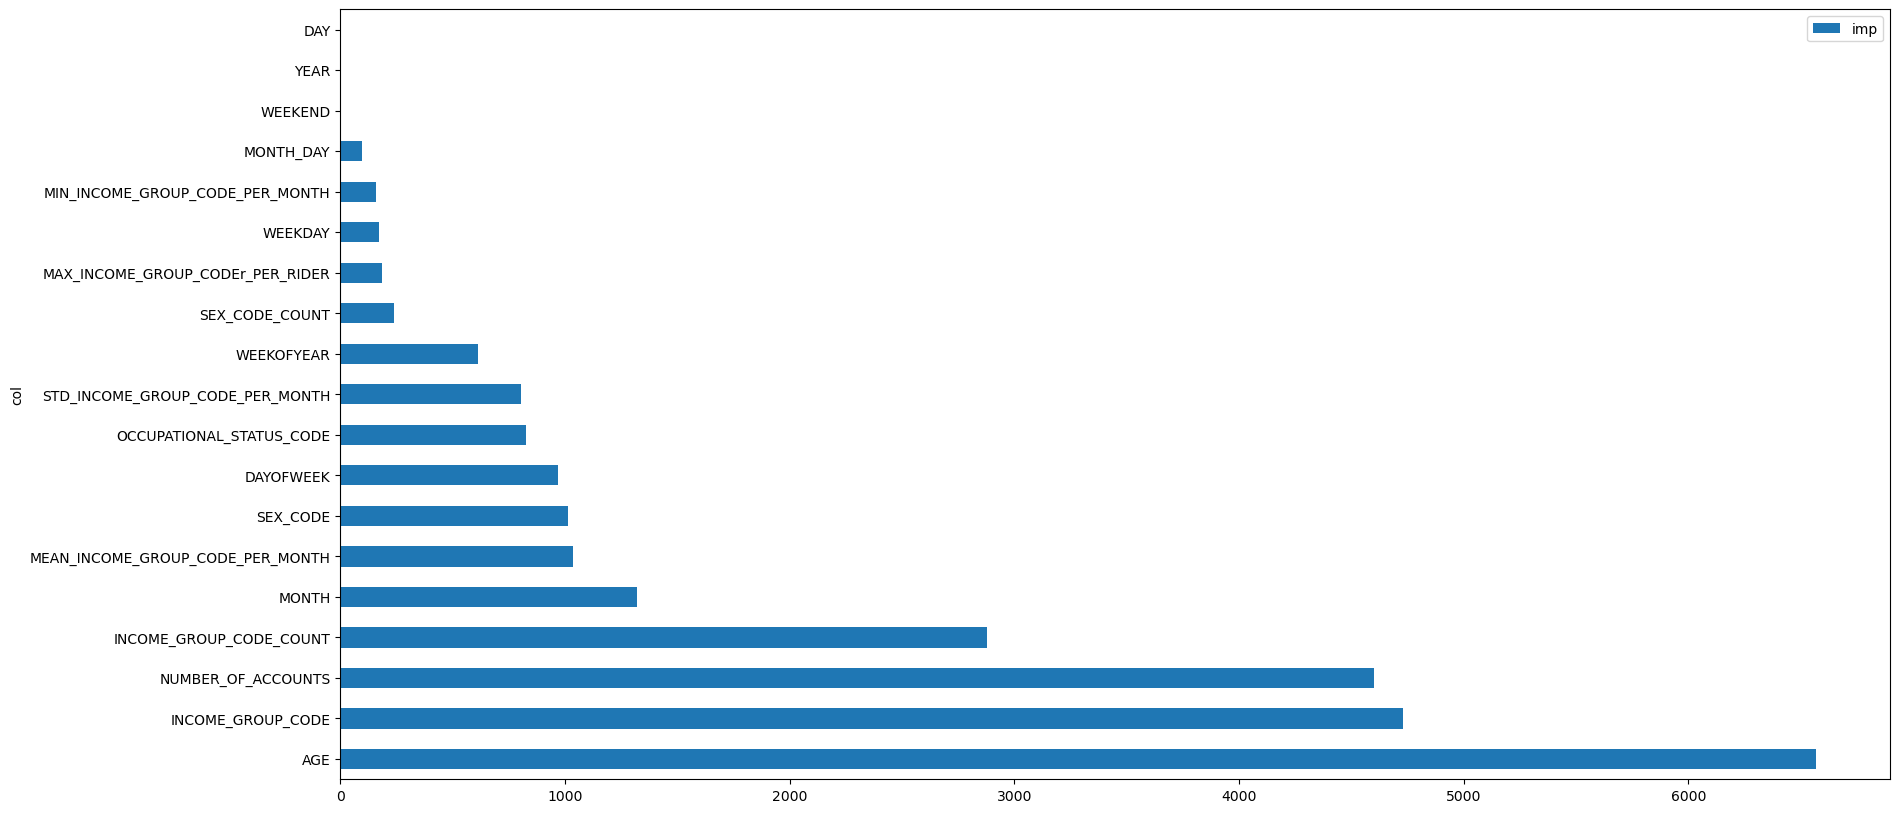

In [48]:
fea_imp = pd.DataFrame({"imp": m.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")

In [49]:
np.mean(y_pred_totcb, 0)

array([28719.45120169,  9248.28284737, 23163.91683134, ...,
       15256.41310768, 11682.4586164 , 22934.90887256])

In [50]:
len(np.mean(y_pred_totcb, 0))

1544

In [51]:
test["DECLARED_NET_INCOME"] = np.mean(y_pred_totcb, 0)

In [52]:
ss.head()

CUSTOMER_IDENTIFIER  DECLARED_NET_INCOME
0  ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...                    0
1  ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...                    0
2  ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...                    0
3  ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...                    0
4  ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...                    0

In [53]:
ss["DECLARED_NET_INCOME"] = np.mean(y_pred_totcb, 0)
ss.head()

CUSTOMER_IDENTIFIER  DECLARED_NET_INCOME
0  ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...         28719.451202
1  ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...          9248.282847
2  ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...         23163.916831
3  ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...         14940.764081
4  ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...          7512.565789

### transforming the prediction


In [54]:
# ss["DECLARED_NET_INCOME"] = np.log1p(abs(ss["DECLARED_NET_INCOME"]))

In [55]:
ss.head()

CUSTOMER_IDENTIFIER  DECLARED_NET_INCOME
0  ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...         28719.451202
1  ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...          9248.282847
2  ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...         23163.916831
3  ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...         14940.764081
4  ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...          7512.565789

In [56]:
ss.to_csv("base_lgb.csv", index=False)

In [57]:
kjlk

NameError: name 'kjlk' is not defined

# Using Catboost

In [ ]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split


def optimize(X, y):
    def objective(trial):
        # Use a LightGBM regressor as the model
        model = LGBMRegressor(
            # Set the number of leaves (i.e. tree complexity) to be optimized
            num_leaves=trial.suggest_int("num_leaves", 2, 256),
            # Set the learning rate to be optimized
            learning_rate=trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
            # Set the number of boosting rounds to be optimized
            n_estimators=trial.suggest_int("n_estimators", 1, 10000),
        )

        # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Evaluate the model on the validation data
        val_predictions = model.predict(X_val)
        val_mae = mean_absolute_error(y_val, val_predictions)

        return val_mae

    # Set up the Optuna study
    study = optuna.create_study(direction="minimize")

    # Run the optimization
    study.optimize(objective, n_trials=100)

    # Get the best trial
    best_trial = study.best_trial

    # Get the best model from the best trial
    best_model = LGBMRegressor(
        num_leaves=best_trial.params["num_leaves"],
        learning_rate=best_trial.params["learning_rate"],
        n_estimators=best_trial.params["n_estimators"],
    )

    # Fit the best model on the full dataset
    best_model.fit(X, y)

    return best_model

In [ ]:
errcb2 = []
y_pred_totcb2 = []
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit

fold = KFold(n_splits=10, random_state=1234, shuffle=True)
i = 1
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2 = CatBoostRegressor(
        iterations=1000,
        logging_level="Silent",
        od_wait=50,
        od_type="Iter",
        learning_rate=0.1,
        depth=8,
        eval_metric="RMSE",
    )
    m2.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        verbose=100,
    )
    preds = m2.predict(X_test)
    print("err: ", np.sqrt(mean_squared_error(y_test, preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test, preds)))
    p2 = m2.predict(test)
    y_pred_totcb2.append(p2)

In [ ]:
p2

In [ ]:
sb = pd.read_csv("SampleSubmission.csv")
sb.head()

In [ ]:
sb["DECLARED_NET_INCOME"] = p2
sb.head()

In [ ]:
sb.to_csv("Catboost.csv", index=False)

In [ ]:
fea_imp = pd.DataFrame({"imp": m2.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")